# **MaldiAMRKit** quick guide

If you haven't installed the package yet, run this:
```bash
pip install maldiamrkit
```

### Import `maldiamrkit`

In [1]:
# Use top-level imports (recommended)
from maldiamrkit import (
    MaldiSpectrum,
    MaldiSet,
    PreprocessingSettings,
    MaldiPeakDetector,
    Warping,
    RawWarping,
    estimate_snr,
)

Other imported packages

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### Visualize `PreprocessingSettings` default parameters 

In [3]:
default_cfg = PreprocessingSettings()
default_cfg.as_dict()

{'trim_from': 2000,
 'trim_to': 20000,
 'savgol_window': 20,
 'savgol_poly': 2,
 'baseline_half_window': 40}

### `MaldiSpectrum` preprocessing and plot

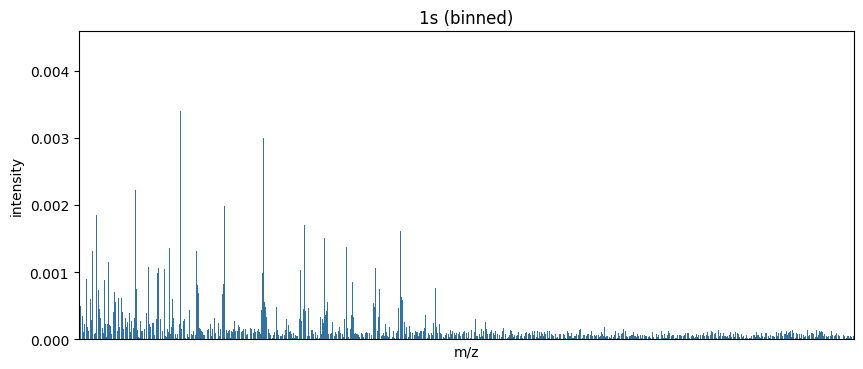

In [4]:
# smoothing, baseline removal, normalisation
spec = MaldiSpectrum(
    "../data/1s.txt"
).preprocess()
# [optional] bin width 3 Da
spec.bin(3)
# plot
_ = spec.plot(binned=True)

Eventually you can activate messages

In [5]:
spec = MaldiSpectrum(
    "../data/1s.txt",
    verbose=True
).preprocess()
spec.bin(3).binned

INFO: Preprocessed spectrum 1s
INFO: Binned spectrum 1s (method=uniform, w=3)


,mass,intensity
0,2000,0.000039
1,2003,0.000041
2,2006,0.000083
3,2009,0.000123
4,2012,0.000109
...,...,...
5995,19985,0.000087
5996,19988,0.000054
5997,19991,0.000048
5998,19994,0.000050


Skipping binning

INFO: Preprocessed spectrum 1s


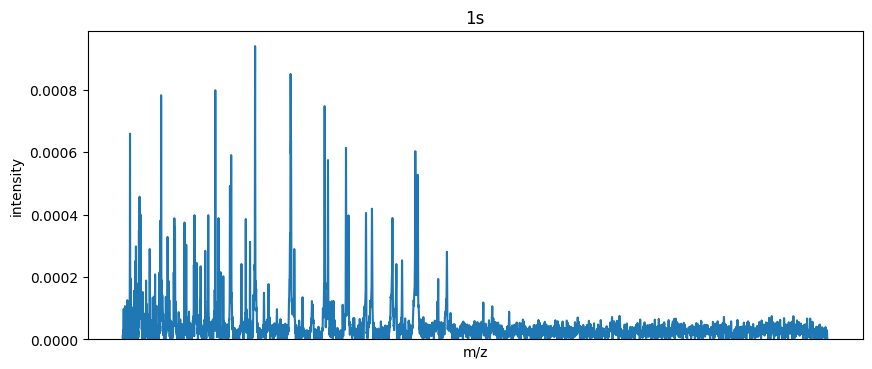

In [6]:
spec = MaldiSpectrum(
    "../data/1s.txt",
    verbose=True
).preprocess()
_ = spec.plot(binned=False)

### Estimate Signal-to-Noise Ratio (SNR)

Use `estimate_snr()` to assess spectrum quality. Higher SNR indicates better signal quality.

In [7]:
# Estimate SNR on preprocessed spectrum
spec = MaldiSpectrum("../data/1s.txt").preprocess()
snr = estimate_snr(spec.preprocessed)
print(f"Signal-to-Noise Ratio: {snr:.1f}")

Signal-to-Noise Ratio: 21.5


### Binning Methods

MaldiAMRKit supports multiple binning strategies: uniform (default), logarithmic, adaptive, and custom.

In [8]:
import numpy as np

spec = MaldiSpectrum("../data/1s.txt").preprocess()

# Uniform binning (default)
spec.bin(bin_width=3)
print(f"Uniform: {len(spec.binned)} bins")
print(spec.bin_metadata.head())

Uniform: 6000 bins
   bin_index  bin_start  bin_end  bin_width
0          0       2000     2003          3
1          1       2003     2006          3
2          2       2006     2009          3
3          3       2009     2012          3
4          4       2012     2015          3


In [9]:
# Logarithmic binning (bin width scales with m/z)
spec.bin(bin_width=3, method="logarithmic")
print(f"Logarithmic: {len(spec.binned)} bins")
print(f"Width at start: {spec.bin_metadata.iloc[0]['bin_width']:.2f} Da")
print(f"Width at end: {spec.bin_metadata.iloc[-1]['bin_width']:.2f} Da")

Logarithmic: 1537 bins
Width at start: 3.00 Da
Width at end: 29.99 Da


In [10]:
# Adaptive binning (smaller bins in peak-dense regions)
spec.bin(method="adaptive", adaptive_min_width=1.0, adaptive_max_width=10.0)
print(f"Adaptive: {len(spec.binned)} bins")
print(f"Min width: {spec.bin_metadata['bin_width'].min():.2f} Da")
print(f"Max width: {spec.bin_metadata['bin_width'].max():.2f} Da")

Adaptive: 4542 bins
Min width: 1.00 Da
Max width: 7.89 Da


In [11]:
# Custom binning (user-defined edges)
custom_edges = np.linspace(2000, 20000, 50)  # 49 bins
spec.bin(method="custom", custom_edges=custom_edges)
print(f"Custom: {len(spec.binned)} bins")
print(spec.bin_metadata.head())

Custom: 49 bins
   bin_index    bin_start      bin_end   bin_width
0          0  2000.000000  2367.346939  367.346939
1          1  2367.346939  2734.693878  367.346939
2          2  2734.693878  3102.040816  367.346939
3          3  3102.040816  3469.387755  367.346939
4          4  3469.387755  3836.734694  367.346939


### Build the `MaldiSet` dataset from a directory containing raw spectra

In [12]:
data = MaldiSet.from_directory(
    "../data/",
    "../data/metadata/metadata.csv",
    aggregate_by=dict(antibiotics="Drug"),
)
X, y = data.X, data.y

X.shape, y.shape

((29, 6000), (29, 1))

In [13]:
y.head()

,Drug
21s,R
16s,S
3s,R
22s,R
29s,S


Plot pseudogel visualization

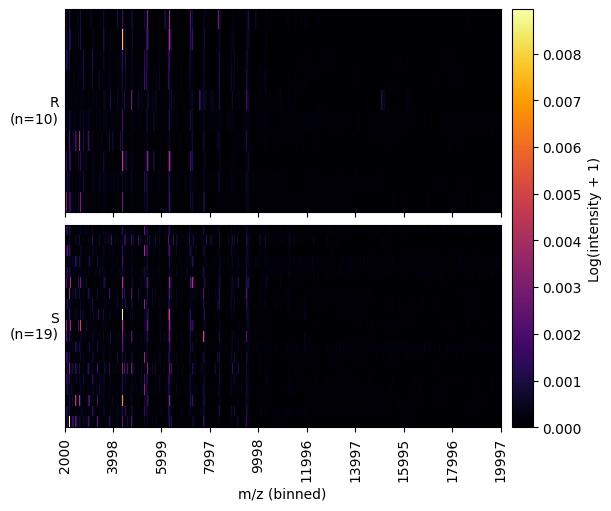

In [14]:
_ = data.plot_pseudogel()

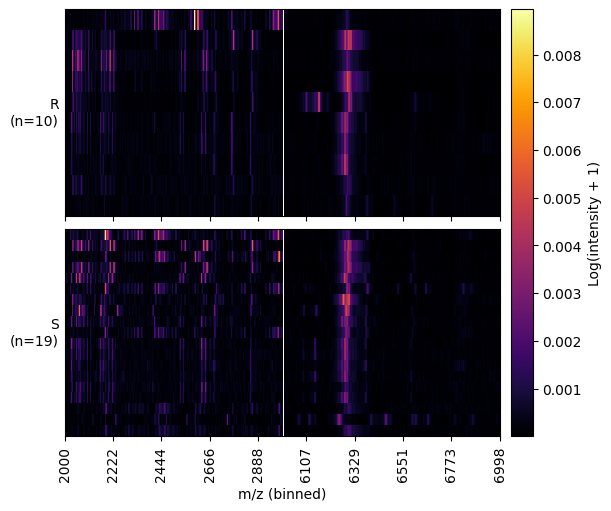

In [15]:
_ = data.plot_pseudogel(
    regions=[(2000, 3000), (6000, 7000)]
)

Map Resistant (and intermediate) strains to 1, susceptible strains to 0

In [16]:
y = y["Drug"].map({
    "S": 0,
    "I": 1,
    "R": 1
})
y.head()

21s    1
16s    0
3s     1
22s    1
29s    0
Name: Drug, dtype: int64

### Use of `MaldiPeakDetector` within a *scikit-learn* `Pipeline`

In [17]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([
    ("peaks", MaldiPeakDetector(binary=False, prominence=1e-8)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
print(f"CV ROC AUC: {scores.mean():.3f} +/- {scores.std():.3f}")

CV ROC AUC: 0.325 +/- 0.302


### Use of `MaldiPeakDetector` with persistent homology (`ph` method)

In [18]:
peak_detector = MaldiPeakDetector(
    method="ph",
    binary=False,
    persistence_threshold=5e-4,
)

peak_detector.fit(X.iloc[:5])
peak_detector.get_peak_statistics(X.iloc[:5])

,n_peaks,mean_intensity,max_intensity
21s,57,0.001352,0.003946
16s,38,0.001509,0.004237
3s,33,0.002453,0.007082
22s,42,0.001926,0.006476
29s,29,0.001157,0.002647


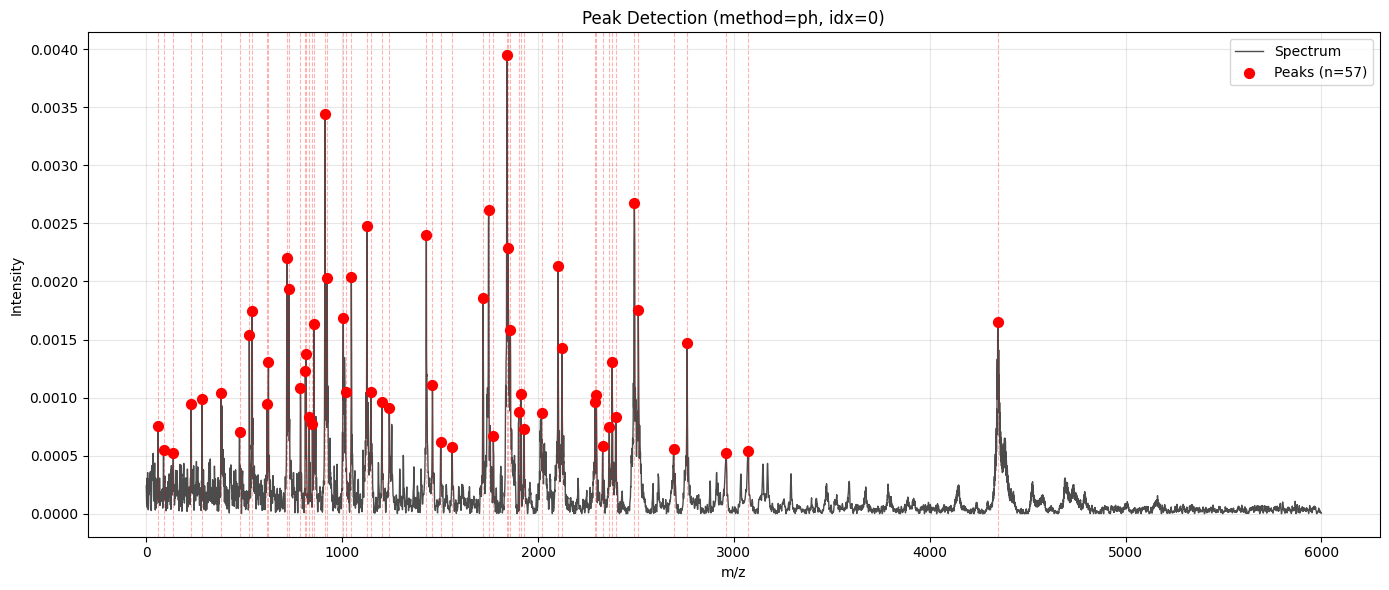

In [19]:
_ = peak_detector.plot_peaks(X.iloc[0])

### Use of `Warping` and `RawWarping` within a *scikit-learn* `Pipeline`

Different warping methods for spectral alignment. We use cross-validation for proper evaluation.

In [20]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Shift method
pipe_shift = Pipeline([
    ("warp", RawWarping(spectra_dir="../data/" , method="shift")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

scores = cross_val_score(pipe_shift, X, y, cv=cv, scoring="roc_auc")
print(f"Shift - CV ROC AUC: {scores.mean():.3f} +/- {scores.std():.3f}")

Shift - CV ROC AUC: 0.658 +/- 0.145


In [21]:
# Linear method
pipe_linear = Pipeline([
    ("warp", Warping(method="linear")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

scores = cross_val_score(pipe_linear, X, y, cv=cv, scoring="roc_auc")
print(f"Linear - CV ROC AUC: {scores.mean():.3f} +/- {scores.std():.3f}")

# Piecewise method
pipe_piecewise = Pipeline([
    ("warp", Warping(method="piecewise", n_segments=10)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])

scores = cross_val_score(pipe_piecewise, X, y, cv=cv, scoring="roc_auc")
print(f"Piecewise - CV ROC AUC: {scores.mean():.3f} +/- {scores.std():.3f}")

Linear - CV ROC AUC: 0.708 +/- 0.201
Piecewise - CV ROC AUC: 0.708 +/- 0.255


### Alignment Quality Assessment

Use `get_alignment_quality()` to measure how well spectra were aligned to the reference.

In [22]:
# Fit warping and check alignment quality
warper = Warping(method="piecewise", n_segments=10)
warper.fit(X)
X_aligned = warper.transform(X)

# Get alignment quality metrics
quality = warper.get_alignment_quality(X, X_aligned)
print(f"Mean correlation improvement: {quality['improvement'].mean():.4f}")
quality.head()

Mean correlation improvement: 0.0056


,correlation_before,correlation_after,improvement,rmse_before,rmse_after
21s,0.491008,0.495938,0.004930,0.000246,0.000244
16s,0.846964,0.846964,0.000000,0.000132,0.000132
3s,0.637013,0.637095,0.000081,0.000247,0.000247
22s,0.614768,0.616134,0.001366,0.000290,0.000290
29s,0.628225,0.628225,0.000000,0.000161,0.000161


### Raw Spectra Warping with `RawWarping`

`RawWarping` performs alignment at full m/z resolution (before binning) for higher precision. It loads raw spectra files during fit/transform and outputs binned data compatible with sklearn pipelines.

In [23]:
# RawWarping operates on original spectrum files
raw_warper = RawWarping(
    spectra_dir="../data/",
    method="piecewise",
    bin_width=3,
    max_shift_da=10.0,
    n_segments=5,
)

# Fit and transform - loads raw files, warps at full resolution, outputs binned
raw_warper.fit(X)
X_raw_aligned = raw_warper.transform(X)
print(f"Output shape: {X_raw_aligned.shape}")

Output shape: (29, 6000)
